In [5]:
import numpy as np
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,RandomizedSearchCV
from sklearn.metrics import average_precision_score,accuracy_score,roc_auc_score,precision_recall_curve,roc_curve,precision_recall_fscore_support
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler,OneHotEncoder
import joblib

# Read UCI's census data sets 'adult.data' & 'adult.test'
features=['age','workclass','fnlwgt','education','edu_num','marital_status',
          'occupation','relationship','race','gender','capital_gain','capital_loss','hours_per_week',
          'native_country','label']
categorical_features= ['workclass','marital_status',
          'occupation','relationship','race','gender','native_country']
num_features=['age','fnlwgt','edu_num','capital_gain','capital_loss','hours_per_week']

df = pd.read_csv('adult.data',header=None,names=features) 
df1 = pd.read_csv('adult.test',header=None,names=features) 
y_train = df['label']
y_test = df1['label']
X_train = df.drop(['label','education'],axis=1)
X_test = df1.drop(['label','education'],axis=1)


In [ ]:
# Train the xgboost classifier using sklearn pipeline.
#
categorical_pipe = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler',RobustScaler())
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_features),
     ('num', numerical_pipe, num_features),
    ],remainder='passthrough')

pipe = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', XGBClassifier(booster='gbtree',missing=None))
])


# fit model no training data
kfold = StratifiedKFold(n_splits=5)
# Random search of xgboost hyper-parameters
params = {'classifier__min_child_weight': [5, 10],
        'classifier__gamma': [1, 1.5, 2, 5],
        'classifier__subsample': [1.0],
        'classifier__n_estimators':[60,80],
        'classifier__scale_pos_weight':[3,4],
        'classifier__max_depth': [4, 5,6]}
random_search = RandomizedSearchCV(pipe, param_distributions=params, n_iter=50,
                                   cv=kfold,scoring='roc_auc',n_jobs=4, verbose=3, random_state=1001)

search = random_search.fit(X_train,y_train)

print(search.best_params_)
# Save the model.
joblib.dump(search.best_estimator_,'model.joblib')
model = search.best_estimator_

In [7]:
# model = joblib.load('model.joblib')


In [9]:
# Print out training performance
y_prob = model.predict_proba(X_train)
predictions = model.predict(X_train)
accuracy = accuracy_score(y_train, predictions)
ap = average_precision_score(y_train, y_prob[:,1],pos_label=' >50K')

print("Training accuracy: %.2f%%,average precision:%.2f%%" % (accuracy * 100.0,ap * 100.0))
result=precision_recall_fscore_support(y_train, predictions,pos_label=' >50K',average='binary')
print("Training:income > $50K ,Precision: {};Recall: {}".format(result[0],result[1]))

Training accuracy: 82.89%,average precision:85.08%
Training:income > $50K ,Precision: 0.5937241948802643;Recall: 0.9169748756536156


Prediction accuracy: 81.83%,average precision:82.65%
Prediction:income > $50K ,Precision: 0.574052429453999;Recall: 0.8939157566302652


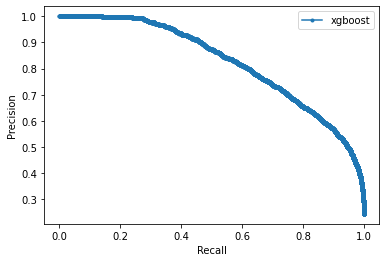

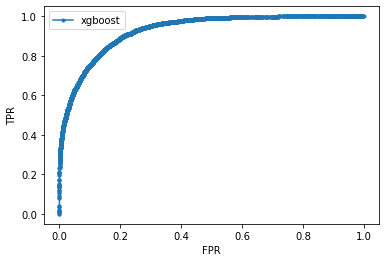

In [10]:
# Print out testing performance
y_prob = model.predict_proba(X_test)

predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
ap = average_precision_score(y_test, y_prob[:,1],pos_label=' >50K')
print("Prediction accuracy: %.2f%%,average precision:%.2f%%" % (accuracy * 100.0,ap * 100.0))
result=precision_recall_fscore_support(y_test, predictions,pos_label=' >50K',average='binary')
print("Prediction:income > $50K ,Precision: {};Recall: {}".format(result[0],result[1]))

precision, recall, thresholds = precision_recall_curve(y_test, y_prob[:,1],pos_label=' >50K')
plt.plot(recall, precision, marker='.', label='xgboost')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1],pos_label=' >50K')
plt.plot(fpr, tpr, marker='.', label='xgboost')
# axis labels
plt.xlabel('FPR')
plt.ylabel('TPR')
# show the legend
plt.legend()
# show the plot
plt.show()